# Kalman Filter for Air Quality
see also 'Optimum Linear Estimation' at https://www.sciencedirect.com/topics/social-sciences/kalman-filter

- Replaces a multiple linear regression (MLR) batch run, runs recursively on an Arduino Atmega1284P as adaptive filter for the MLR regression coefficients
- Kalman Filter is derived from https://github.com/zziz/kalman-filter
- For theory, please read https://en.wikipedia.org/wiki/Kalman_filter
- Key is to set the covariance of the process noise matrix to a zero matrix! See hint in 'Optimum Linear Estimation' at https://www.sciencedirect.com/topics/social-sciences/kalman-filter.
- I send a big thank you to those who provided these great basis contributions
- Click on the button 'Re-start the kernel, and then re-run the whole notebook' above

## Basic Kalman Filter class from https://github.com/zziz/kalman-filter:

In [1]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)             # Predicted (a priori) state estimate
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q      # Predicted (a priori) estimate covariance
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)                                  # Innovation or measurement pre-fit residual
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))           # Innovation (or pre-fit residual) covariance
        #print("\nUpdate: self.H = ", self.H)
        #print("\nUpdate: self.P = ", self.P)
        #print("\nUpdate: self.R = ", self.R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))          # Optimal Kalman gain
        #print("\nUpdate: Kalman gain matrix K  = ", K)
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T) # Updated (a posteriori) estimate covariance 

## Read historian.csv (same input file as 'Multiple linear regression for BME680 gas readings of a single sensor.ipynb' is using

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from datetime import datetime

import numpy as np


dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S,%f')
  
df0 = pd.read_csv("historian.csv", sep=';', thousands=".", decimal=",", skiprows = [0,1,2],dtype={'High': np.float64, 'Low': np.float64}, header = None, encoding= 'unicode_escape',  parse_dates=[0], date_parser=dateparse, names = [ 'Datum', 'Mode', 'raw_gas_resistance', 'relative_humidity', 'temperature'])

# print first 5 lines of the pandas dataframe

df0.head(19)


,Datum,Mode,raw_gas_resistance,relative_humidity,temperature
0,2020-12-31 16:26:56.439,2,147800,36.9,23.278
1,2020-12-31 16:30:32.862,2,147800,36.9,22.800
2,2020-12-31 16:30:32.866,2,147800,35.6,22.800
3,2020-12-31 16:30:32.873,2,157780,35.6,22.800
4,2020-12-31 16:35:04.477,2,157780,35.6,22.600
5,2020-12-31 16:35:04.486,2,157780,36.5,22.600
6,2020-12-31 16:35:04.492,2,161480,36.5,22.600
7,2020-12-31 16:39:36.091,2,161480,36.5,22.700
8,2020-12-31 16:39:36.099,2,161480,36.8,22.700
9,2020-12-31 16:39:36.106,2,162460,36.8,22.700


In [3]:
# keep every 3rd row (CCU historian is tacking every change of a datapoint separately)
df = df0[(df0.index % 3 == 0)]

df.head(7)

,Datum,Mode,raw_gas_resistance,relative_humidity,temperature
0,2020-12-31 16:26:56.439,2,147800,36.9,23.278
3,2020-12-31 16:30:32.873,2,157780,35.6,22.800
6,2020-12-31 16:35:04.492,2,161480,36.5,22.600
9,2020-12-31 16:39:36.106,2,162460,36.8,22.700
12,2020-12-31 16:44:07.740,2,160520,37.2,22.800
15,2020-12-31 16:48:39.353,2,158000,37.5,22.900
18,2020-12-31 16:53:10.973,2,155280,37.8,22.900


Print values of Pandas dataframe. Please x-check if they meet your expectation!

In [4]:
df.values

array([[Timestamp('2020-12-31 16:26:56.439000'), 2, 147800, 36.9, 23.278],
       [Timestamp('2020-12-31 16:30:32.873000'), 2, 157780, 35.6, 22.8],
       [Timestamp('2020-12-31 16:35:04.492000'), 2, 161480, 36.5, 22.6],
       ...,
       [Timestamp('2021-01-14 16:15:55.504000'), 2, 209040, 26.8, 26.4],
       [Timestamp('2021-01-14 16:20:29.140000'), 2, 205100, 27.1, 26.1],
       [Timestamp('2021-01-14 16:25:02.895000'), 2, 201900, 26.4, 26.2]],
      dtype=object)

In [5]:
df0.head(-1)

,Datum,Mode,raw_gas_resistance,relative_humidity,temperature
0,2020-12-31 16:26:56.439,2,147800,36.9,23.278
1,2020-12-31 16:30:32.862,2,147800,36.9,22.800
2,2020-12-31 16:30:32.866,2,147800,35.6,22.800
3,2020-12-31 16:30:32.873,2,157780,35.6,22.800
4,2020-12-31 16:35:04.477,2,157780,35.6,22.600
...,...,...,...,...,...
14018,2021-01-14 16:20:29.135,2,209040,27.1,26.100
14019,2021-01-14 16:20:29.140,2,205100,27.1,26.100
14020,2021-01-14 16:25:02.887,2,205100,27.1,26.200
14021,2021-01-14 16:25:02.889,2,205100,26.4,26.200


In [6]:
df.head(-1)

,Datum,Mode,raw_gas_resistance,relative_humidity,temperature
0,2020-12-31 16:26:56.439,2,147800,36.9,23.278
3,2020-12-31 16:30:32.873,2,157780,35.6,22.800
6,2020-12-31 16:35:04.492,2,161480,36.5,22.600
9,2020-12-31 16:39:36.106,2,162460,36.8,22.700
12,2020-12-31 16:44:07.740,2,160520,37.2,22.800
...,...,...,...,...,...
14007,2021-01-14 16:08:06.854,2,189640,27.8,26.100
14010,2021-01-14 16:09:02.681,2,213600,28.0,25.000
14013,2021-01-14 16:11:22.754,2,218780,26.9,25.500
14016,2021-01-14 16:15:55.504,2,209040,26.8,26.400


## Formulas for calculating the absolute humidity

In [7]:
import numpy as np
# Create a function that  calculates the absolute humidity from the two arguments 'temperature' and 'relative humidity'
# see for details https://www.kompf.de/weather/vent.html or  https://rechneronline.de/barometer/luftfeuchtigkeit.php for x-checking the calculated result

a = 6.112
b = 17.67
c = 243.5

# Compute saturated water vapor pressure in hPa
# Param t - temperature in °C
def svp(t):
  svp = a * np.exp((b*t)/(c+t))
  return svp

# Compute actual water vapor pressure in hPa
# Param rh - relative humidity in %
# Param t - temperature in °C
def vp(rh, t):
  vp = rh/100. * svp(t)
  return vp

# Compute the absolute humidity in g/m³
# Param rh - relative humidity in %
# Param t - temperature in °C
def calculate_absolute_humidity(t, rh):
  mw = 18.016 # kg/kmol (Molekulargewicht des Wasserdampfes)
  rs = 8314.3 # J/(kmol*K) (universelle Gaskonstante)
  ah = 10**5 * mw/rs * vp(rh, t)/(t + 273.15)
  #return the absolute humidity in [g/m³]
  return ah


pd.set_option('mode.chained_assignment', None)
# now apply the above defined formulas to get the pandas dataframe column 'absolute_humidity'
df['absolute_humidity'] = calculate_absolute_humidity(df['temperature'], df['relative_humidity'])

## Plot the calculated absolute humidity

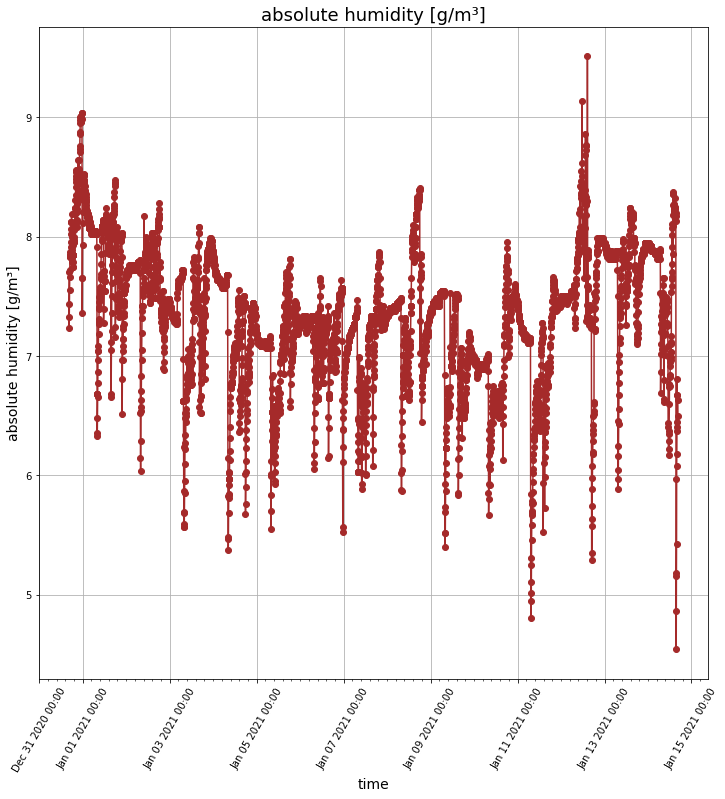

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
fig, ax = plt.subplots(figsize=(12, 12))
plt.xticks(rotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.plot_date(df['Datum'], df['absolute_humidity'], linestyle='solid', color='brown')         
plt.title('absolute humidity [g/m³]', fontsize=18)
plt.xlabel('time', fontsize=14)
plt.ylabel('absolute humidity [g/m³]', fontsize=14)
plt.grid(True)
plt.show()

Print again the first 5 lines of the Pandas dataframe. Check if a column for the absolute humidity has been added.

In [9]:
df.head()

,Datum,Mode,raw_gas_resistance,relative_humidity,temperature,absolute_humidity
0,2020-12-31 16:26:56.439,2,147800,36.9,23.278,7.704152
3,2020-12-31 16:30:32.873,2,157780,35.6,22.800,7.232304
6,2020-12-31 16:35:04.492,2,161480,36.5,22.600,7.330595
9,2020-12-31 16:39:36.106,2,162460,36.8,22.700,7.433362
12,2020-12-31 16:44:07.740,2,160520,37.2,22.800,7.557352


Create a subset of the measurement data: 'raw_gas_resistance','temperature','absolute_humidity'

In [10]:
my_observations = df[['raw_gas_resistance','temperature','absolute_humidity']] 
my_observations.head()

,raw_gas_resistance,temperature,absolute_humidity
0,147800,23.278,7.704152
3,157780,22.800,7.232304
6,161480,22.600,7.330595
9,162460,22.700,7.433362
12,160520,22.800,7.557352


Create a numpy array of measurements for further processing

In [11]:
list_of_rows = [list(row) for row in my_observations.values]

Print the first four elements of list of lists i.e. rows

In [12]:
print(list_of_rows[:4])

[[147800.0, 23.278, 7.70415152311762], [157780.0, 22.8, 7.232304207423894], [161480.0, 22.6, 7.330594890416396], [162460.0, 22.7, 7.433362386991288]]


Convert the selection of measurements to a numpy array

In [13]:
np.array(list_of_rows)
measurements = np.array(list_of_rows)
print("number of measurement datapoints = ", len(measurements))

number of measurement datapoints =  4675


## Set the parameters of the Kalman filter

- Kalman filter with a zero covariance matrix for the process noise is well known a the recursive minimum least-square error (LMMSE) filter for a linear system with some assumptions on auto- and cross-correlations of process and measurement noise and initial state.

- observation vector y                         :   [raw_gas_resistance]; n=1; note: 'temperature' and 'aH' are NOT part of the observation vector! 
- system state vector X                        :   [VOC_resistance, alpha_temperature, beta_ah, delta_intercept]; m=4
- state transition matrix F                    :   identity matrix (m, n)
- observation transition matrix H              :   initial identidy matrix (1,m); then set to state dependant
- covariance matrix of the process noise Q     :   zero matrix (m,m)
- covariance matrix of the observation noise R :   matrix(1,1) with very small value

In [14]:
F = np.eye(4)
H = np.array([ [1, 1, 1, 1] ]).reshape(1, 4)
# key ist to set Q to a zero matrix, in this case the Kalman filter works an ordinary least squares minimizer filter
Q = np.array([ [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0] ]).reshape(4, 4)
# set covariance of gast resistance measurements also to a very small value
R = np.array([ [0.0001] ]).reshape(1, 1)

print("\nF = ",F)  # the state-transition model;
print("\nInitial H = ",H)  # the observation model;
print("\nQ = ",Q)  # covariance of the process noise
print("\nR = ",R)  # covariance of the observation noise



F =  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Initial H =  [[1 1 1 1]]

Q =  [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]

R =  [[0.0001]]


## Initialize the Kalman filter

In [15]:
kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []
compensated_gas_resistance=[]
states=[]

#print("raw gas resistance measurements =", measurements[:,0])

print("dim measurements : ", measurements.shape)

last_index = len(measurements)

print ("last index of measurement array = ", last_index)



dim measurements :  (4675, 3)
last index of measurement array =  4675


## Run the Kalman filter

In [16]:
it = 0  # iteration index
#print("\nState vector kf.x= ", kf.x)
for z in measurements:
    zg = z[0] # raw_gas_resistance
    # make observation model matrix state dependant
    H = np.array([[1, z[1], z[2], 1]]).reshape(1, 4)
    # z[1]: measured temperature
    # z[2]: calculated absolute humidity ah(T, rH)
    # estimated state vector x:
    # x[0]: estimated VOC resistance
    # x[1]: estimated regression coefficient for T temperature dependency
    # x[2]: estimated regression coefficient for aH aboslute humidity dependency
    # x[3]: estimated intercept of linear regression
    kf.H = H
    it = it + 1
    #print("\nState vector kf.x= ", kf.x)
    #print results for the last sample of the measurement sequence
    if ((it == last_index)):  # print results of last measurement index 
        print ("\nIteration index = ", it)
        print ("\n")
        print("\nState vector kf.x= ", kf.x)
        print("\nObservation vector z = ", z)
        print("\nObservation transition matrix kf.H = ", kf.H)
        print("\nKalman filter prediction = ", kf.predict())
        print("\nKalman filter update = ",np.dot(H,  kf.predict()))
        print ("\n\n")
    predictions.append(np.dot(H,  kf.predict()))
   
    compensated_gas_resistance.append(zg-kf.predict()[1,0]*z[1]-kf.predict()[2,0]*z[2])
    #compensated_gas_resistance.append(-kf.predict()[1,0]*z[1]-kf.predict()[2,0]*z[2])
    #compensated_gas_resistance.append(-kf.predict()[1,0]*z[1])
    #rint("\nraw gas resistance                = ",zg)
    #print("\ntemperature coefficent prediction = ",kf.predict()[1,0])
    #print("\ntemperature                       = ",z[1])
    #print("\ntemperature compensation          = ",-kf.predict()[1,0]*z[1])
    #print("\nhumidity coefficent prediction    = ",kf.predict()[2,0])
    #print("\nabsolute humidity                 = ",z[2])
    #print("\nhumidity compensation             = ",-kf.predict()[2,0]*z[2])
    #print("\nKalman state prediction          = ",kf.predict())
    #print("\ntmperature coefficent prediction = ",kf.predict()[1,0])
    #print("\ncompensated gas resistance       = ",zg-kf.predict()[1,0]*z[1]-kf.predict()[2,0]*z[2])
    states.append(kf.x)
    kf.update(zg)  #only zg raw_gas_resistance is an observation variable!


Iteration index =  4675



State vector kf.x=  [[121968.07677364]
 [  6567.30461868]
 [-37295.71424912]
 [121968.07625382]]

Observation vector z =  [2.01900000e+05 2.62000000e+01 6.50024362e+00]

Observation transition matrix kf.H =  [[ 1.         26.2         6.50024362  1.        ]]

Kalman filter prediction =  [[121968.07677364]
 [  6567.30461868]
 [-37295.71424912]
 [121968.07625382]]

Kalman filter update =  [[173568.30527887]]





## Plot the results of the Kalman filter

### Plot measured gas resistance versus corrected gas resistance (compensation of temperature and humidity interference)

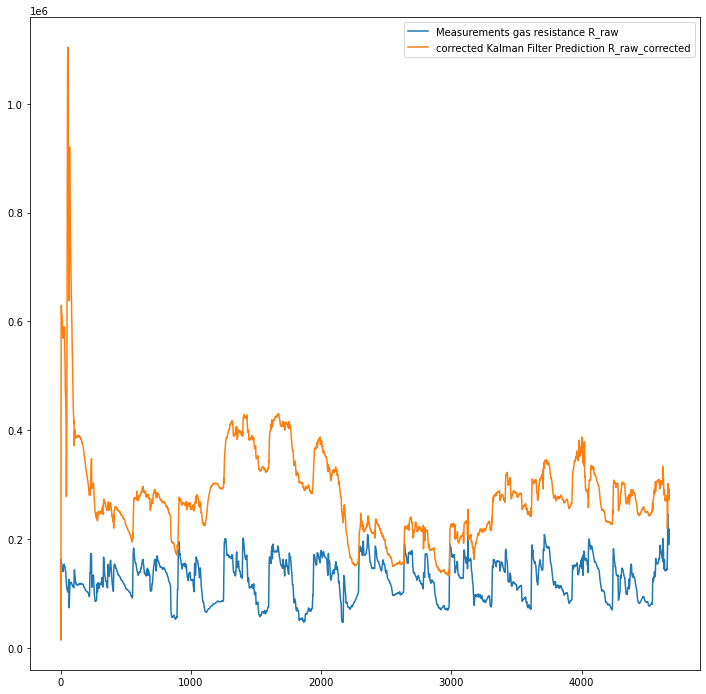

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(range(len(measurements)), measurements[:,0], label = 'Measurements gas resistance R_raw')
ax.plot(range(len(predictions)), compensated_gas_resistance[:], label = 'corrected Kalman Filter Prediction R_raw_corrected')
ax.legend()
plt.show()

## Plot alpha (temperature coefficient) and beta (aH coefficient) regression coefficients

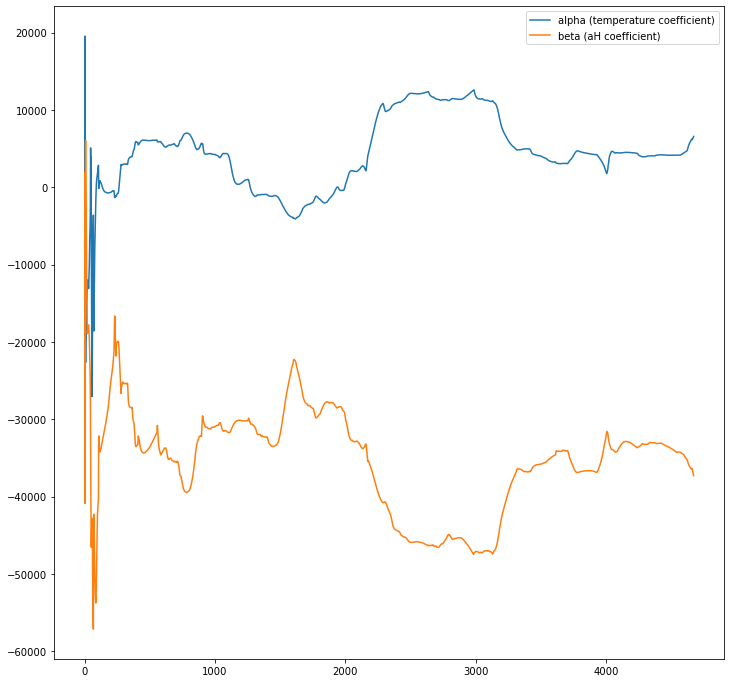

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(range(len(predictions)), np.array(states)[:,1], label = 'alpha (temperature coefficient)')
ax.plot(range(len(predictions)), np.array(states)[:,2], label = 'beta (aH coefficient)')
ax.legend()
plt.show()

# Regression results of the recursive minimum least-square error (LMMSE) Kalman filter

In [19]:
print("\nNumber of captured data points used for online regression using Kalman filter  = %11d" % len(measurements))

print("\n\nLinear regression coefficient of temperature interference alpha_LMMSE          = %11.3lf" % kf.predict()[1][0])
print("Linear regression coefficient of absolute humidity interference beta_LMMSE     = %11.3lf" % kf.predict()[2][0])
print("\n\n")


Number of captured data points used for online regression using Kalman filter  =        4675


Linear regression coefficient of temperature interference alpha_LMMSE          =    6603.555
Linear regression coefficient of absolute humidity interference beta_LMMSE     =  -37355.402





# You are done! Congratulations!